In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [22]:
train_classes_df=pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [23]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [24]:
sample_submission_df=pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [25]:
test_1= !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test_2= !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test_1[0])+float(test_2[0])

In [26]:
from skimage import io #converts image to array'
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
image_number = 10
img=io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))

In [28]:
img.shape

(256, 256, 3)

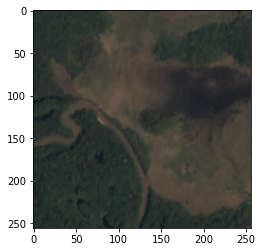

In [29]:
plt.imshow(img)

In [30]:
train_classes_df[train_classes_df['image_name']== 'train_10']

,image_name,tags
10,train_10,agriculture clear primary slash_burn water


In [31]:
unique_labels=set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)
train_classes=train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels=list(unique_labels)
print(unique_labels)

['haze', 'bare_ground', 'blow_down', 'road', 'slash_burn', 'habitation', 'clear', 'primary', 'artisinal_mine', 'agriculture', 'conventional_mine', 'partly_cloudy', 'cloudy', 'blooming', 'water', 'selective_logging', 'cultivation']


In [32]:
len(unique_labels)

17

In [33]:
assert len(train_classes['image_name'].unique())== train_classes.shape[0]

In [34]:
#one hot encoding the labels in train classes
for tag in unique_labels:
    train_classes[tag]=train_classes['tags'].apply(lambda x:1 if tag in x.split() else 0)
train_classes['image_name']=train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x))
train_classes.head()

,image_name,tags,haze,bare_ground,blow_down,road,slash_burn,habitation,clear,primary,artisinal_mine,agriculture,conventional_mine,partly_cloudy,cloudy,blooming,water,selective_logging,cultivation
0,train_0.jpg,haze primary,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0
2,train_2.jpg,clear primary,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0


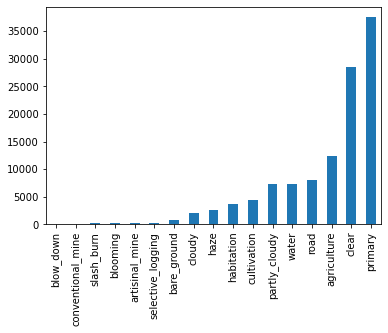

In [35]:
train_classes[unique_labels].sum().sort_values().plot.bar() # an histogram of the number of tags

In [36]:
# creating a function that generates a concurrent matrix (a matrix that contains the number of overlaps of pairs
# of tags)
def get_concurrent_matrix(tags):
    concur_df = train_classes[tags]
    concur_matrix = concur_df.T.dot(concur_df)
    mask = np.triu(np.ones((len(tags), len(tags))))
    sns.heatmap(concur_matrix, cmap=sns.cm.rocket_r, mask=mask)
    
    return concur_matrix

In [37]:
# classifying the tags into the three categories of 'atmospheric condition', 'common land cover' and 
# 'rare land cover'
atm_condition_tags = ['clear', 'partly_cloudy','cloudy', 'haze']
common_land_cover_tags = ['primary', 'water', 'habitation', 'agriculture', 'road', 'cultivation', 'bare_ground']
rare_land_cover_tags = [tag for tag in unique_labels if (tag not in atm_condition_tags) and (tag not in \
                                                                                        common_land_cover_tags)]

,clear,partly_cloudy,cloudy,haze
clear,28431,0,0,0
partly_cloudy,0,7261,0,0
cloudy,0,0,2089,0
haze,0,0,0,2697


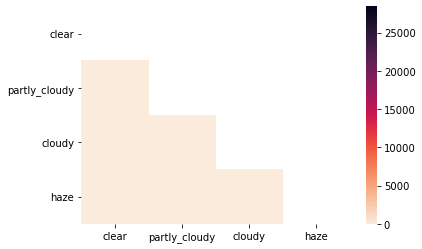

In [38]:
# concurrent matrix of atmospheric condition tags
atm_tags_concurrent_matrix = get_concurrent_matrix(atm_condition_tags) 
atm_tags_concurrent_matrix

,primary,water,habitation,agriculture,road,cultivation,bare_ground
primary,37513,7001,3469,11972,7728,4455,683
water,7001,7411,915,2712,2125,868,206
habitation,3469,915,3660,2737,2786,895,163
agriculture,11972,2712,2737,12315,6034,3377,225
road,7728,2125,2786,6034,8071,1294,323
cultivation,4455,868,895,3377,1294,4477,89
bare_ground,683,206,163,225,323,89,862


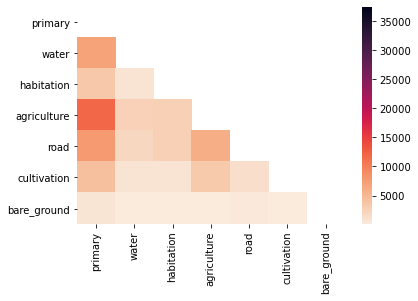

In [39]:
get_concurrent_matrix(common_land_cover_tags) # concurrent matrix of common land cover tags

,blow_down,slash_burn,artisinal_mine,conventional_mine,blooming,selective_logging
blow_down,98,2,0,0,1,1
slash_burn,2,209,0,0,2,2
artisinal_mine,0,0,339,4,0,6
conventional_mine,0,0,4,100,0,0
blooming,1,2,0,0,332,7
selective_logging,1,2,6,0,7,340


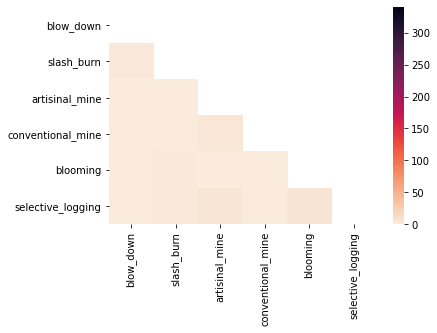

In [40]:
get_concurrent_matrix(rare_land_cover_tags) # concurrent matrix of rare land cover

,haze,bare_ground,blow_down,road,slash_burn,habitation,clear,primary,artisinal_mine,agriculture,conventional_mine,partly_cloudy,cloudy,blooming,water,selective_logging,cultivation
haze,2697,41,0,394,3,129,0,2670,5,672,2,0,0,4,613,5,202
bare_ground,41,862,4,323,10,163,747,683,40,225,10,74,0,3,206,13,89
blow_down,0,4,98,2,2,3,85,98,0,22,0,13,0,1,3,1,8
road,394,323,2,8071,36,2786,6295,7728,110,6034,59,1382,0,10,2125,151,1294
slash_burn,3,10,2,36,209,41,173,209,0,119,0,33,0,2,24,2,126
habitation,129,163,3,2786,41,3660,3090,3469,29,2737,36,441,0,4,915,13,895
clear,0,747,85,6295,173,3090,28431,27668,307,9150,70,0,0,311,5502,308,3527
primary,2670,683,98,7728,209,3469,27668,37513,324,11972,94,7175,0,332,7001,340,4455
artisinal_mine,5,40,0,110,0,29,307,324,339,38,4,27,0,0,299,6,18
agriculture,672,225,22,6034,119,2737,9150,11972,38,12315,24,2493,0,32,2712,65,3377


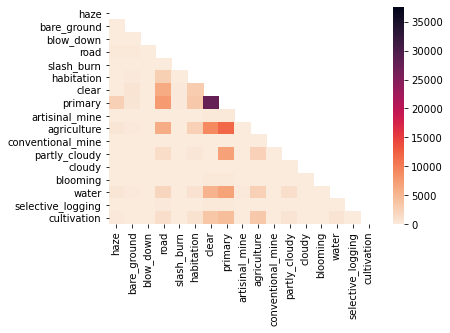

In [41]:
get_concurrent_matrix(unique_labels) # concurrent matrix of all tags

In [42]:
# let's check if indeed every image must have one atmospheric condition tag
total_atm_tags = np.matmul(np.array(atm_tags_concurrent_matrix), (np.ones((4, 1)))).sum()
print(total_atm_tags)
total_atm_tags == train_classes.shape[0]

40478.0


False

In [43]:
# the above cell returned false, it seems only one image doesn't contain any atmospheric condition.
# let's check it out
image_atm_tags_df = train_classes.loc[:, ['image_name']+atm_condition_tags] 
image_without_atm_df = image_atm_tags_df.loc[image_atm_tags_df.sum(axis=1) == 0]
image_without_atm_df

,image_name,clear,partly_cloudy,cloudy,haze
24448,train_24448.jpg,0,0,0,0


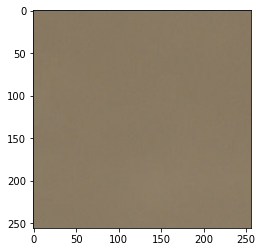

In [44]:
# let's view this image without any atmospheric condition
image_without_atm_name = image_without_atm_df.loc[24448, 'image_name']
image_without_atm = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/{}'.format( \
                                                                                    image_without_atm_name))
plt.imshow(image_without_atm)

In [45]:
# let's checkout the tags associated with this image above
train_classes_df[train_classes_df['image_name'] == image_without_atm_name[:-4]]

,image_name,tags
24448,train_24448,water


In [46]:
# let's view a sample image say 'train_10.jpg' 
image_number = 10
sample_img = io.imread('/kaggle/input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
r, g, b = sample_img[:, :, 0], sample_img[:, :, 1], sample_img[:, :, 2]
sample_img.shape

(256, 256, 3)

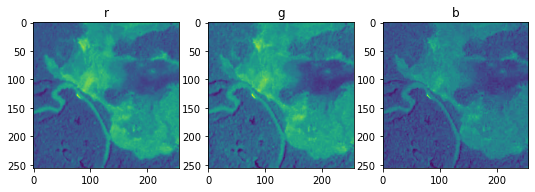

In [47]:
fig = plt.figure()
fig.set_size_inches(12, 4)
for ind, (img, channel) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'))):
    a = fig.add_subplot(1, 4, ind+1)
    a.set_title(channel)
    plt.imshow(img)
    
# displaying the red, green and blue channels seperately

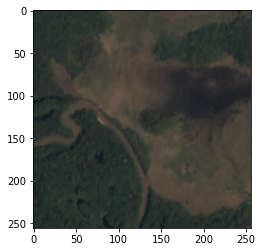

In [48]:
plt.imshow(sample_img) # displaying all channels at once

In [49]:
y_col=list(train_classes.columns[2:])
#initializing an image generator with some data augmentation
image_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
#loading images from dataframe
X=image_gen.flow_from_dataframe(dataframe=train_classes, \
  directory='../input/planets-dataset/planet/planet/train-jpg/',x_col='image_name',y_col=y_col, \
  target_size=(128,128),class_mode='raw',seed=1,batch_size=128)

Found 40479 validated image filenames.


In [50]:
y_col

['haze',
 'bare_ground',
 'blow_down',
 'road',
 'slash_burn',
 'habitation',
 'clear',
 'primary',
 'artisinal_mine',
 'agriculture',
 'conventional_mine',
 'partly_cloudy',
 'cloudy',
 'blooming',
 'water',
 'selective_logging',
 'cultivation']

In [51]:
x109=X[0][0][109] #first batch,image,109th imgage
y109=X[0][1][109]#first batch,label,109th label
print('each images shape is {}'.format(x109.shape))
print('each images label is {}'.format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/label'.format(X[0][0].shape[0]))
print('40490/128 is {:.2F},so the batch will have {} images/label'.format(40479/128,X[316][0].shape[0]))

each images shape is (128, 128, 3)
each images label is (17,)
we have 317 batches
each batch has 128 images/label
40490/128 is 316.24,so the batch will have 31 images/label


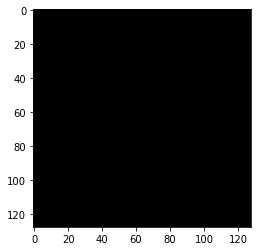

In [52]:
plt.imshow(x109/255) # divided by 255 so the image can be displayed

In [53]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [54]:
# defining a function to calculate fbeta score

def fbeta(ytrue, ypred, beta=2, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    beta_squarred = float(beta)**2
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    fb = (beta_squarred+1) * precision * recall / (precision*beta_squarred + recall + epsilon)
  
    return fb

In [55]:
# creating a function to calculate multi-label accuracy 

def multi_label_acc(ytrue, ypred, threshold=0.2, epsilon=1e-7):
    # threshold is set to 0.2 to maximize recall since f2 score is recall biased
    # epsilon is set to 1e-7 to avoide Nan values due to zero division
    
    ytrue = tf.cast(ytrue, tf.float32) # casts ytrue as a float
    # convert ypred to bool, then to float
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(threshold)), tf.float32) 
    
    tp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(3.0)), tf.float32), axis=1) 
    fp = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(1.0)), tf.float32), axis=1)
    fn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(2.0)), tf.float32), axis=1)
    tn = tf.reduce_sum(tf.cast(tf.equal((2.0*ytrue + ypred), tf.constant(0.0)), tf.float32), axis=1)
    
    acc = (tp+tn) / (tp+fp+fn+tn+epsilon)  
    
    return acc

In [56]:
# creating a function to build a sequential model

def build_model():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    opt = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [57]:
# initializing callbacks
early_stopping = EarlyStopping(monitor='val_fbeta', patience=10, mode='max', verbose=1)
reduced_lr = ReduceLROnPlateau(monitor='val_fbeta', patience=3, cool_down=2, mode='max')
save_best_check_point = ModelCheckpoint(filepath='best_model2.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [58]:
train_image_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_gen=train_image_gen.flow_from_dataframe(dataframe=train_classes, \
          directory='../input/planets-dataset/planet/planet/train-jpg/',x_col='image_name',y_col=y_col, \
                                              target_size=(128,128),class_mode='raw',seed=0,batch_size=128,subset='training')
val_gen=train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/',x_col='image_name',y_col=y_col, \
                                             target_size=(128,128),class_mode='raw',seed=0,batch_size=128,subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [59]:
step_train_size=int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size=int(np.ceil(val_gen.samples / train_gen.batch_size))

In [60]:
step_train_size

253

In [61]:
step_val_size

64

In [62]:
model1 = build_model() # building a sequential model for training

# fitting the model
model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=50, callbacks=[early_stopping, reduced_lr, save_best_check_point], )

80142336/80134624 [==============================] - 0s 0us/step
Epoch 1/50
253/253 [==============================] - 174s 687ms/step - loss: 0.1381 - multi_label_acc: 0.9239 - fbeta: 0.8741 - val_loss: 0.1496 - val_multi_label_acc: 0.9228 - val_fbeta: 0.8525
Epoch 2/50
253/253 [==============================] - 127s 504ms/step - loss: 0.1016 - multi_label_acc: 0.9499 - fbeta: 0.9120 - val_loss: 0.1051 - val_multi_label_acc: 0.9522 - val_fbeta: 0.9085
Epoch 3/50
253/253 [==============================] - 127s 502ms/step - loss: 0.0937 - multi_label_acc: 0.9535 - fbeta: 0.9188 - val_loss: 0.0993 - val_multi_label_acc: 0.9520 - val_fbeta: 0.9141
Epoch 4/50
253/253 [==============================] - 127s 501ms/step - loss: 0.0874 - multi_label_acc: 0.9562 - fbeta: 0.9241 - val_loss: 0.0996 - val_multi_label_acc: 0.9543 - val_fbeta: 0.9148
Epoch 5/50
253/253 [==============================] - 128s 507ms/step - loss: 0.0810 - multi_label_acc: 0.9587 - fbeta: 0.9294 - val_loss: 0.0943 - val

In [64]:
model2 = build_model() # building a sequential model for testing

#loading in the weights of the trained model
model2.load_weights('best_model2.hdf5')

In [65]:
sample_submission=sample_submission_df.copy()
sample_submission['image_name']=sample_submission['image_name'].apply(lambda x:'{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [66]:
test1_df=sample_submission.iloc[:40669]['image_name'].reset_index().drop('index',axis=1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [67]:
test1_df.shape

(40669, 1)

In [68]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [69]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

318/318 [==============================] - 159s 501ms/step


In [70]:
test_file_names1=test_gen1.filenames
pred_tags1=pd.DataFrame(pred1)
pred_tags1=pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x>0.5]),axis=1)
result1=pd.DataFrame({'image_name':test_file_names1 ,'tags':pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,clear primary
4,test_4.jpg,primary partly_cloudy


In [71]:
test2_df=sample_submission.iloc[40669:]['image_name'].reset_index().drop('index',axis=1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [72]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

Found 20522 validated image filenames.


In [73]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
pred2 = model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

161/161 [==============================] - 81s 505ms/step


In [74]:
test_file_names2=test_gen2.filenames
pred_tags2=pd.DataFrame(pred2)
pred_tags2=pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x>0.5]),axis=1)
result2=pd.DataFrame({'image_name':test_file_names2,'tags':pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,clear primary
1,file_1.jpg,primary agriculture partly_cloudy
2,file_10.jpg,road primary
3,file_100.jpg,clear primary water
4,file_1000.jpg,clear primary


In [75]:
final_result = pd.concat([result1, result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
final_result = final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(final_result.shape)
final_result.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear primary
1,test_1.jpg,clear primary
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,clear primary
4,test_4.jpg,primary partly_cloudy


In [76]:
assert sum(sample_submission['image_name']==final_result['image_name'])==61191

In [77]:
final_result['image_name']=final_result['image_name'].apply(lambda x :x[:-4])
final_result.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,primary partly_cloudy
3,test_3,clear primary
4,test_4,primary partly_cloudy


In [78]:
final_result.to_csv('seventh_submission.csv', index=False) # saving the predictions